In [40]:
from datetime import datetime
import torch
from torchcam.methods import XGradCAM
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [41]:
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]


In [42]:

FINDINGS = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
    'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema',
    'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

In [43]:
# Suponha que model seja o seu modelo carregado
model = torch.load('results/densenet_best.pth')['model']
model.eval()
model.cpu()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [44]:
# Função para carregar a imagem e transformá-la em um tensor
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD)
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

In [45]:
# Função para obter as principais probabilidades e índices
def get_top_probabilities(output, topk=3):
    # Aplicar softmax para obter probabilidades
    probabilities = torch.nn.functional.softmax(output, dim=1)
    top_probs, top_idxs = torch.topk(probabilities, topk)
    return top_probs.squeeze(), top_idxs.squeeze()

In [46]:
def generate_cam(image_tensor, model, top_idx, original_image_size):
    # Inicialize o extrator de CAM com o modelo e a camada-alvo
    cam_extractor = XGradCAM(model, target_layer=model.features.norm5)  # Verifique se 'norm5' é o correto para o seu modelo
    
    # Realize a passagem para frente através do modelo
    out = model(image_tensor)
    # Calcule o CAM para a classe de interesse
    activation_map = cam_extractor(out.squeeze().argmax().item(), out)
    
    # Verifica se o mapa de ativação é uma lista e pega o primeiro item se for
    if isinstance(activation_map, list):
        activation_map = activation_map[0]
    
    # Redimensiona o CAM para o tamanho da imagem de entrada
    result = transforms.Resize(original_image_size)(activation_map.unsqueeze(0))
    
    # Normaliza o CAM para ter valores entre 0 e 1 para melhor visualização
    result = result.squeeze().numpy()
    result = (result - result.min()) / (result.max() - result.min())

    return result

In [47]:
def process_image(image_path, model):
    image_tensor = load_image(image_path)
    original_image = Image.open(image_path).convert('RGB')
    original_image_size = original_image.size  # Obter o tamanho da imagem original
    output = model(image_tensor)
    top_probs, top_idxs = get_top_probabilities(output)
    
    # Gera o CAM para cada um dos top_idxs
    cam = generate_cam(image_tensor, model, top_idxs[0], original_image_size)
    
    plt.imshow(original_image, alpha=1)
    plt.imshow(cam, cmap='hot', alpha=0.5)  # Ajuste de transparência para o CAM
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.show()
    
    
    # Apresentando os resultados de texto
    print(f"As principais probabilidades são: {top_probs.detach().numpy()}")
    print(f"Achados correspondentes: {[FINDINGS[i] for i in top_idxs]}")

In [48]:
import pandas as pd

# Load the dataset
df = pd.read_csv('nih_labels.csv')

# Function to get true labels for a given image index
def get_true_labels(image_index):
    # Select the row with the given image index
    row = df[df['Image Index'] == image_index]

    # Extract labels (assuming all labels start from 'Cardiomegaly' column to the last disease label)
    labels = row.loc[:, 'Cardiomegaly':'Consolidation']  # Adjust columns names as per your dataset

    # Filter out columns with 1 (True)
    true_labels = labels.columns[labels.eq(1).any()].tolist()

    return true_labels

C:\Users\Murilo\Documents\repos\tcc-sptech-2023-g15\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


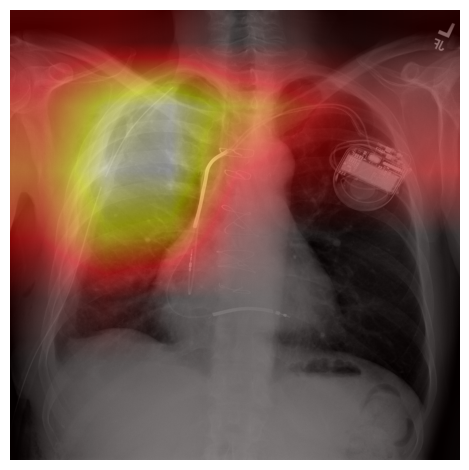

As principais probabilidades são: [0.11365507 0.09709625 0.07160805]
Achados correspondentes: ['Pneumothorax', 'Emphysema', 'Cardiomegaly']
True labels: ['Cardiomegaly', 'Emphysema', 'Pneumothorax']


In [49]:
# Exemplo de uso
image_path = 'images/00000013_040.png'
image_index = image_path.split('/')[-1]
process_image(image_path,model)
true_labels = get_true_labels(image_index)
print(f"True labels: {true_labels}")